# Importing libraries

In [125]:
import pandas as pd
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import tensorflow as tf
import csv
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import matplotlib.pyplot as plt
import json
from operator import itemgetter 


# Data loading and cleaning 

In [126]:
Reddit_df = pd.read_csv("/home/ege/selenium/r_news.csv"  )
contractions = pd.read_csv("/home/ege/Desktop/kaggle/NLP/archive/contractions.csv")
Reddit_df.dropna( inplace = True)
Reddit_df = Reddit_df[['r/news']]
Reddit_df.drop_duplicates(inplace = True)

In [127]:
Reddit_df.head()

,r/news
0,Ticketmaster pleads guilty to illegally gainin...
1,Have a fun & relaxed farming experience with y...
38,Black man wrongfully detained by maskless poli...
39,"Dawn Wells, Mary Ann on 'Gilligan's Island,' d..."
40,Japan gave key intel on China's Uighur crackdo...


In [128]:
with open('/home/ege/Desktop/kaggle/NLP/word_index.json', 'r') as fp:
    tokens = json.load(fp)


# Defining preprocessing functions

In [129]:
def df_to_dict(data):
    dictionary = dict()
    col_names = data.columns
    for _ in range(data.shape[0]):
        dictionary[data[col_names[0]].iloc[_]] = data[col_names[1]].iloc[_]
    return dictionary  

In [130]:
def lower(data):
    columns = data.columns
    for col in columns:
        data[col] = data[col].apply(str)
        data[col] = data[col].str.lower()
    return data 

In [131]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_data(news):

    # Replace all URls with '<url>'
    news = re.sub(urlPattern,'<url>',news )
    # Replace @USERNAME to '<user>'.
    news = re.sub(userPattern,'<user>', news)
    
    # Replace 3 or more consecutive letters by 2 letter.
    news = re.sub(sequencePattern, seqReplacePattern, news)

    # Replace all emojis.
    news = re.sub(r'<3', '<heart>', news)
    news = re.sub(smileemoji, '<smile>', news)
    news = re.sub(sademoji, '<sadface>', news)
    news = re.sub(neutralemoji, '<neutralface>', news)
    news = re.sub(lolemoji, '<lolface>', news)

    for contraction, replacement in contractions_dict.items():
        news = news.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    news = re.sub(alphaPattern, ' ', news)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    news = re.sub(r'/', ' / ', news)
    return news

In [132]:
def split_func(df):
    data = df.values.tolist()
    clean_list =[]
    for sentences in data:
        clean_list.append(sentences[0].split())
    return  clean_list   

In [133]:
def tokenizer_based_on_json(data, tokens):
    sentences = 0
    word = 0
    while True:
        try:
            data[sentences][word] = tokens[split_list[sentences][word]]
            word += 1
            if word  == len(data[sentences]):
                sentences += 1
                word = 0
            if      sentences == len(data):
                break
        except:
             data[sentences][word] = "<oov>"
    return data

# Data preprocessing

In [134]:
Reddit_df = lower(Reddit_df)
contractions_dict    = df_to_dict(contractions)

In [135]:
Reddit_df['r/news'] = Reddit_df['r/news'].apply(preprocess_data)

In [136]:
split_list = split_func(Reddit_df)

In [137]:
tokenized_list = tokenizer_based_on_json(split_list , tokens)

In [138]:
news_padded = pad_sequences(tokenized_list , maxlen= max([len(x) for x in tokenized_list]) , 
                            padding= 'post', truncating= 'post')

# Importing saved tensorflow model

In [139]:
model = tf.keras.models.load_model("/home/ege/saved_model/my_model")

# Predictions

In [140]:
predictions = model.predict(news_padded)

In [158]:
predictions_list = []
for pred in predictions:
    if pred > 0.7:
        predictions_list.append(1)
    else:
        predictions_list.append(0)
        

# Exploring predictions

In [159]:
print("negative news : " , predictions_list.count(0) , "positive news " , predictions_list.count(1))

negative news :  230 positive news  28


<ipython-input-166-e1562d8ba15d>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.bar(labels,numbers ,color = 'rg')


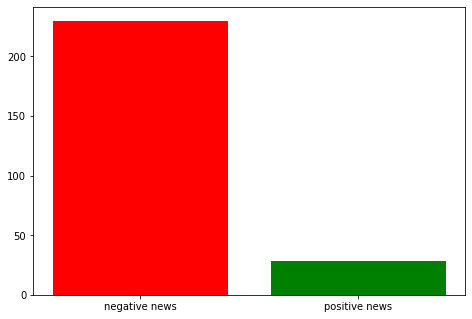

In [166]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['negative news', 'positive news']
numbers = [ predictions_list.count(0) , predictions_list.count(1)]
ax.bar(labels,numbers ,color = 'rg')
plt.show()

In [161]:
Poz_index = [i for i, x in enumerate(predictions_list) if x == 1]
Neg_index = [i for i, x in enumerate(predictions_list) if x == 0]

In [162]:
positive_news = []
negative_news = []
for poz in Poz_index:
    positive_news.append(Reddit_df['r/news'].iloc[poz])
for neg in Neg_index:
    negative_news.append(Reddit_df['r/news'].iloc[neg])    

In [163]:
number_of_sentences = 7
print("-- Some negative news labeled by model -- " , "\n\n")
for sen in range(number_of_sentences):
     print(sen+1 , negative_news[random.randrange(0,len(negative_news))],".")
    

-- Some negative news labeled by model --  


1 ontario confirms canada s 1st known cases of uk coronavirus variant .
2  highly suspicious  fire at black church in massachusetts being investigated as arson .
3 some overflowing la hospitals resort to putting patients in gift shops  conference rooms .
4 city of edmonton sues former employees accused of stealing  1 6m in false invoicing scheme .
5 russia gives kremlin critic navalny an ultimatum  return immediately or face jail .
6 shelly beach rescue  fisherman saves kayaker  helicopter sent to scene .
7 seafarer exemption from new covid restrictions recommended by european commission .


In [168]:
number_of_sentences = 7
print("-- Some positive news labeled by model -- ", "\n\n")
for sen in range(number_of_sentences):
     print( sen+1 , positive_news[random.randrange(0,len(positive_news))],".")
    

-- Some positive news labeled by model --  


1 l a  coronavirus update  county surpasses 7 00 covid 19 hospitalizations for first time .
2 beverly hills eatery reportedly planning indoor  speakeasy  nye party draws police interest .
3 azerbaijani energy ministry  acwa power company sign agreement on wind farm project .
4 amazon to acquire wondery in podcast push .
5 brazil vice president tests positive for coronavirus .
6 pentagon sends 7 00 gallons of eggnog and 21 00 pounds of ham to u s  troops around the world .
7 archaeologists uncover ancient street food shop in pompeii .
